<a href="https://colab.research.google.com/github/rmoglin/BIX_F24/blob/main/Moglin_lab5_cbgt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5 - CBGT pathways

This lab has 3 main components designed to go over how corticobasal ganglia-thalamic (CBGT) circuits make decisions. We will use a model of this sytem to run simulations and investigate the effects of tuning different aspects of the circuit.

Sections:
1. Run the baseline network, visualize simulated brain region activity patterns, and understand interactions.
1. Investigate the effects of direct pathway strength.
1. Investigate the effects of indirect pathway strength.

## Section 0 - Setup

Run all of the following code cells, which set up the environment and define several helper functions that we will use to run CBGT decision simulations.



### Load in CBGT modeling code library

The code cell below sets the current working directory for Colab, into which we will load the CBGT library. This is the usual `/content` directory.

In [1]:
cd /content

/content


Copy the CBGT simulation library from the CoAx lab GitHub to our Colab notebook (in the `/content` directory specified above).

In [2]:
!git clone https://github.com/CoAxLab/CBGT

Cloning into 'CBGT'...
remote: Enumerating objects: 604, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 604 (delta 10), reused 5 (delta 0), pack-reused 581 (from 1)
Receiving objects: 100% (604/604), 13.84 MiB | 8.54 MiB/s, done.
Resolving deltas: 100% (322/322), done.


This next code line sets Colab's working directory to the CGBT library which we've just copied in.

In [3]:
import os
os.chdir('CBGT')

The code cell below imports libraries that the later code will need. These are libraries for performing mathematical calculations, structuring data, and plotting figures.

The code also sets configurations for a prettier plots.

In [4]:
# import libraries and configure plots
import sys
import pandas as pd
import numpy as np
import random
from future.utils import listvalues
from copy import deepcopy

import cbgt.netgen as ng
import cbgt.analyzefx as afx
from cbgt import vis, sim

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore")

%matplotlib inline
clrs = ['#347fff', '#febe08']
eclrs = ['#1657de', '#f5a005']

rc = {'lines.solid_capstyle': u'butt'}
sns.set(style='ticks', rc=rc, font_scale=1.4)

This next code cell specifies a directory in our Colab environment for saving data so that the simulations we run can log their records.

The code cell also specifies default model parameters, including the number of choices (`Choices = 2`) in the task.

The code also saves a preset of dMSN and iMSN weights for each action/choice channel (see `dMSN=[1.01, 0.99]`). This simulates the condition of the network after some learning. Here we have weight of 1.01 for the left dMSNs vs 0.99. for right dMSNs. This simulates how the network might look after learning that the right choice was more rewarding than the left.

Note: in this lab, we will only be using the `presetLow` preset, left and right dMSN weightings are closer (a slightly higher conflict condition).

In [5]:
# specify saving directory

parentDir = 'cbgtDemoTEST'
savedir = os.path.join(os.path.expanduser('~'), parentDir)
if not os.path.isdir(savedir):
    os.mkdir(savedir)

# specify certain model parameters

BaseStim = 0
Stim = 2.54
Dynamic = 30.0
Choices = 2
rampingCTX = True
popscale = .3
Start=200

# save dMSN/iMSN weight presets for each choice

presetLow = ng.set_post_learning_weights(dMSN=[1.01, 0.99], iMSN=[1.0,1.0])
presetHi = ng.set_post_learning_weights(dMSN=[1.03, 0.98], iMSN=[1.0,1.0])
presets = [presetLow, presetHi]

conds = ['low', 'high']
condABC = ['a', 'b']
cond12 = [1, 2]

savedirs = [os.path.join(savedir, c) for c in conds]
saveLow, saveHi = savedirs
saveTest=os.path.join(savedir, 'test')

presetDict = dict(zip(conds, presets))
condOrder = dict(zip(conds, condABC))
condLevel = dict(zip(conds+['test'], cond12+[0]))

This next code cell defines and builds the CBGT network which we will use to run simulations. The code defines distributiuons of background activity for each brain region in the network and specifies connections between the regions.

In [6]:
# helper functions to specify connection efficiacies for certain pathways

def get_sampling_params(scale, direct_strength, indirect_strength):

    # set strengths of background inputs/currents
    CxSTR      =    0.2
    CxTh       =    0.03
    CxFSI      =    0.165
    D1STR_GPi  =    direct_strength * 1.10
    D2STR_GPeP =    indirect_strength * 1.65
    STN_GPeP_A =    0.07
    STN_GPeP_N =    4.01
    STN_GPi    =    0.0324
    GPi_Th     =    0.067
    ThSTR      =    0.34
    ThCx       =    0.02

    mu = dict(Cx={'STR':CxSTR, 'Th':CxTh, 'FSI':CxFSI},
                Th={'STR':ThSTR, 'Cx':ThCx},
                D1STR={'GPi': D1STR_GPi},
                D2STR={'GPeP': D2STR_GPeP},
                STN={'GPi': STN_GPi},
                GPi={'Th': GPi_Th})
    sd = {i:{j: mu[i][j]*scale for j in list(mu[i])} for i in list(mu)}
    return mu, sd

# assign the background inputs to each brain region accordingly
def sample_network_efficacies(muEff, sdEff, N):
    X = {}
    nuclei = list(muEff)
    for i in nuclei:
        targets = list(muEff[i])
        X[i] = {}
        for j in targets:
            X[i][j] = np.random.normal(muEff[i][j], sdEff[i][j], N)
    return X

# build the network with specified connections
def build_single_network(X, idx=0):

    Cx={'STR': X['Cx']['STR'][idx],
        'Th': X['Cx']['Th'][idx],
        'FSI': X['Cx']['FSI'][idx]}

    D1STR={'GPi': X['D1STR']['GPi'][idx]}
    D2STR={'GPeP': X['D2STR']['GPeP'][idx]}

    STN={'GPi': X['STN']['GPi'][idx]}

    GPi={'Th': X['GPi']['Th'][idx]}

    Th={'STR': X['Th']['STR'][idx],
        'Cx': X['Th']['Cx'][idx]}

    return ng.getConEff(Cx=Cx, D1STR=D1STR, D2STR=D2STR, STN=STN, GPi=GPi, Th=Th)

This code cell defines a helper function for running a bath of simulations. The number of simulations (runs of the model leading to a single choice) to perform is specified via the `batch_size` parameter. The simulations are independent and do not cause plasticity (learning/changing in weights) - instead they run the network each time with the simulated post-learning weights we specified earlier (specifically using the low preset we defined earlier - see `preset = presetDict['low']`).

In [7]:
# code to run a batch of simulations

def runBatch(batch_size, direct_strength, indirect_strength, parallel = 1):
  N_subj = 1
  sdScale = 0

  conProb = ng.getConProb()
  muEff, sdEff = get_sampling_params(sdScale, direct_strength, indirect_strength)
  X = sample_network_efficacies(muEff, sdEff, N=N_subj)
  subj_eff_dicts = [build_single_network(X, idx=i) for i in range(N_subj)]
  idx = 0
  conEff_i = subj_eff_dicts[idx]

  stim = 2.5
  preset = presetDict['low']

  ng.setDirectory(saveTest)

  np.random.seed(seed=np.random.randint(0,1000))
  sweepcount = ng.configureSweep(0, experiment='mc', preset=preset, Start=Start,
                                popscale=popscale, BaseStim=BaseStim, Choices=Choices,
                                WrongStim=stim, RightStim=stim, Dynamic=Dynamic,
                                rampingCTX=True,
                                conProb=conProb,
                                conEff=conEff_i)

  ng.compileAndRunSweepALL(batch_size, 0, 1, parallel)

The code cell below just defines a helper function that we will use to collect and structure simulation  reaction time and accuracy results into a nice data table.

In [8]:
# code to compile the behavioral data into a dataframe

def readResults(batch_size):
    results = ng.readAllTrialResults(batch_size,0,1)
    rtdata = pd.DataFrame(columns=['rt','accuracy'])
    for result in results[0][:batch_size]:
        temp = ng.findOutputs(result)['decision made']
        row = pd.Series({'rt':temp['delay'], 'accuracy':(1-temp['pathvals'][0])})
        # rtdata = rtdata.append(row, ignore_index=True)
        rtdata = pd.concat([rtdata, row.to_frame().T], ignore_index=True)
    return rtdata

## Section 1 - Running the baseline network

In this section we will run the baseline network, visualize simulated brain region activity patterns, and note interactions to get a sense of how the CGBT network implements decisions.

### About this network model

This simulation has been repackaged from (Dunovan et al., 2019).
* There are two parallel action channels which compete against each other, one for the ‘Left’ action and one for the ‘Right’ action.
* Each action channel contains its own cortex/striatum/GPe/GPi/thalamus populations.
* Each trial, stimulation is applied to the cortex, which drives activity in the striatum.
* Some striatal neurons inhibit the GPe (this is the indirect pathway), while others inhibit the GPi (the direct pathway). The ultimate result is a disinhibition of the thalamus, and the thalamus population (either Left or Right) which rises fastest represents the selected action.
* The cortico-striatal connections have been tipped slightly in the favor of the Left action (representing the Left action being slightly more rewarding on average). So, a Left decision by the network is considered ‘Correct’ (since the ‘Left’ action has the highest expected reward), while a Right decision by the network is considered ‘Incorrect’.

![](https://raw.githubusercontent.com/CoAxLab/BiologicallyIntelligentExploration/main/Labs/CBGT_screenshot.png)

### How selection works in this model

During the selection process (between choices during decision making), stimulation is applied to the cortex, causing cortical activity to ramp upwards. The cortex then feeds into the direct and indirect populations of the striatum, which then affects the firing rates in other areas of the basal ganglia. The diagram in the lecture slides shows which populations are excitatory (increase activation) and which are inhibitory (reduce activation).


---
### Question 1.1

During the selection process, will the activity of the following populations increase or decrease? [Assume that the hyperdirect pathway from the cortex to the subthalamic nucleus (STN) in red is NOT undergoing any changes.]

In [9]:
# Fill in the areas below with your answers ("inc" or "dec")

# |inc/dec| Region
# +-------+-----------------------------------------------------------------
# |  inc  | Cortex   - increase, due to applied current
# |  inc  | Thalamus - increase, this area receives the output of the basal ganglia network
# |  inc  | dMSN (striatal neurons in green which start the direct pathway)
# |  dec | iMSN (striatal neurons in blue which start the indirect pathway)
# |  inc  | GPe  (external globus pallidus, in blue)
# |  dec  | GPi  (internal globus pallidus)
# |  inc  | STN  (subthalamic nucleus)

Note: network dynamics can be very complicated and depend on a lot of factors - there's no way to look at a circuit diagram and tell for certain how populations will behave in response to input. Just make your best guess.

### Running code

Run the code below to perform a single simulation with baseline parameters and plot the firing rates of the brain region cell populations.

In [10]:
# set variables
batch_size = 1
direct_strength = 1.00
indirect_strength = 1.00
# note: pathway strengths are in arbitrary units, where 1.0 = baseline

In [11]:
# run the batch
runBatch(batch_size, direct_strength, indirect_strength)

In [12]:
# produce a dataframe with reaction times and accuracies
rt_data = readResults(batch_size)
rt_data

,rt,accuracy
0,248.008942,1.0


RT:	448.01ms
Acc:	Correct



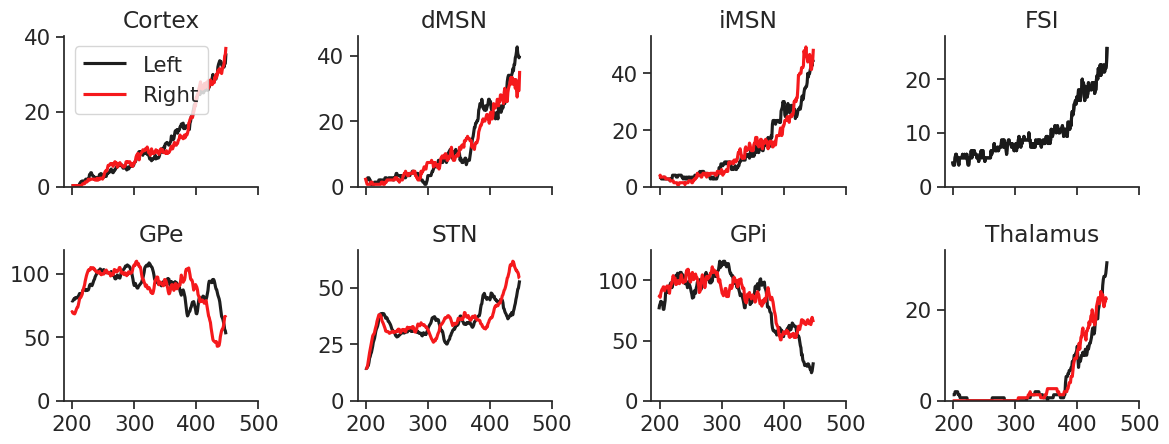

In [13]:
# plot the first trial from the batch
# 'Left' channel is "correct"
vis.plot_trial_rates(t=0)

---
### Question 1.2

What behavior did the network display? Did it choose the Left or Right action? Was this choice the correct or incorrect action? What was the reaction time? Hint: look at the graph of thalamic activity.

__Answer:__

It displayed the right action. the reaction time was 448.01 ms. This was the correct action

---
### Question 1.3

Look at the ramping activity in cortex, striatum (dMSN and iMSN), and thalamus. Do the left and right sub-populations change their activity in opposite ways (one ramps up while the other ramps down)? Or do the left and right activities both ramp upwards together?

__Answer:__

The dMSN and iMSN subpopulations ramp upwards together. The thalalmus, both subpops ramp up but the right side does so more steeply.

---
### Question 1.4

Looking at the actual firing rates, which populations ramped in which directions? Does this match what you expected?

Cortex: both ramped up
dMSN: both ramp up
iMSN: both ramp up
Thalamus: both ramp up
FSI: left ramp up (no right)
GPe: both ramp down
STN: both ramp down
GPi: both ramp down

## Section 2 - Investigating the effects of direct pathway strength

Let's start this next section with some predictions.

---
### Question 2.1:
When the strength of the direct pathway is increased, what will happen to the network's average reaction time?  

Hint: Reaction time equals the time between the presentation of a stimulus (increased current applied to the cortex) and a decision (thalamic activity crosses a threshold).

__Answer:__

when you increase the strength of the direct pathway, the average reaction time will decrease. This is because direct pathway is the "go" pathway, leading to faster decisions.

---
### Question 2.2

When the strength of the direct pathway is increased, what will happen to the network's decision accuracy?

__Answer:__

The decision accuracy would not change. This is because both the left and right areas are affected so it would not have an affect on the decision accuracy.



### Let's test  your predictions. First, run the cells below to generate a batch of baseline data for comparison.

Note: The reaction time effects should be consistent, but there's a ton of randomness in network accuracy, so unless you run a large batch (like 100) the accuracy values might not be what you'd expect.

In [14]:
batch_size = 20 # more runs will take more time
direct_strength = 1.00
indirect_strength = 1.00

*For me, the code block below took a bit over 2 minutes to run on Colab.*

In [15]:
# run the batch and produce the dataframe
# note: if you receive an error while running the sims, you might have made too large of a parameter change.
runBatch(batch_size, direct_strength, indirect_strength)
rt_data_baseline = readResults(batch_size)
rt_data_baseline # check out the data table

,rt,accuracy
0,235.008148,1.0
1,218.007111,1.0
2,239.008392,1.0
3,235.008148,1.0
4,242.008575,1.0
5,263.009857,1.0
6,256.009430,1.0
7,225.007538,0.0
8,232.007965,1.0
9,202.006134,1.0


### Now, run the code below, where direct_strength is set to 1.10.

In [16]:
batch_size = 20 # more runs will take more time
direct_strength = 1.10
indirect_strength = 1.00

*For me, the code block below took a bit over 2 minutes to run on Colab.*

In [17]:
# run the batch and produce the dataframe
# note: if you receive an error while running the sims, you might have made too large of a parameter change.
runBatch(batch_size, direct_strength, indirect_strength)
rt_data_direct_up = readResults(batch_size)
#rt_data_direct_up

In [18]:
# calculate and print the mean values for rt and accuracy

print('Baseline mean values:')
print(rt_data_baseline.mean())
print()

print('Increased direct pathway strength mean values:')
print(rt_data_direct_up.mean())

Baseline mean values:
rt          239.358414
accuracy      0.850000
dtype: float64

Increased direct pathway strength mean values:
rt          233.858078
accuracy      0.700000
dtype: float64


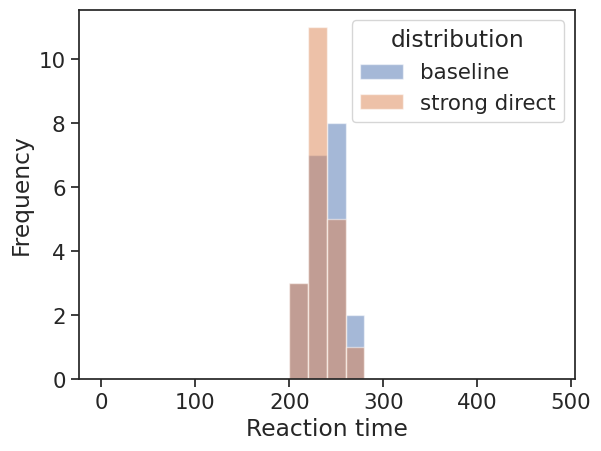

In [19]:
# plot a histogram of reaction times

plt.hist(rt_data_baseline.rt,  bins=np.arange(0,500,20), alpha=0.5, label='baseline')
plt.hist(rt_data_direct_up.rt, bins=np.arange(0,500,20), alpha=0.5, label='strong direct')
plt.xlabel('Reaction time')
plt.ylabel('Frequency')
plt.legend(title='distribution')

---
### Question 2.3

What was the actual relationship between direct pathway strength and reaction time?

__Answer:__

inversely related, as direct pathway strength increased, reaction time decreased. Whith the strong direct pathway, the reaction time was very frequently at approx 220.

## Section 3: The effects of indirect pathway strength

### Question 3.1: Predict effect on reaction time
When the strength of the indirect pathway is increased, what will happen to the network's average reaction time?

__Answer:__

The reaction time should increase becuase the indirect pathway introduces inhibition, slowing down decision making

---
### Question 3.2

When the strength of the indirect pathway is increased, what will happen to the network's decision accuracy?

__Answer:__

The accuracy should increase becuase the indirect pathway inhibits competing actions, slowing down reaction time, resulting in improvement in accuracy.

### Run the code below, where indirect_strength is set to 1.10 (and direct_strength is set back to 1.00).

In [20]:
batch_size = 20
direct_strength = 1.00
indirect_strength = 1.10

*For me, the code block below took a bit over 2 minutes to run on Colab.*

In [21]:
runBatch(batch_size, direct_strength, indirect_strength)
rt_data_indirect_up = readResults(batch_size)
#rt_data_indirect_up

In [22]:
# calculate and print the mean values for rt and accuracy

print('Baseline mean values:')
print(rt_data_baseline.mean())
print()

print('Increased indirect pathway strength mean values:')
print(rt_data_indirect_up.mean())

Baseline mean values:
rt          239.358414
accuracy      0.850000
dtype: float64

Increased indirect pathway strength mean values:
rt          242.90863
accuracy      0.85000
dtype: float64


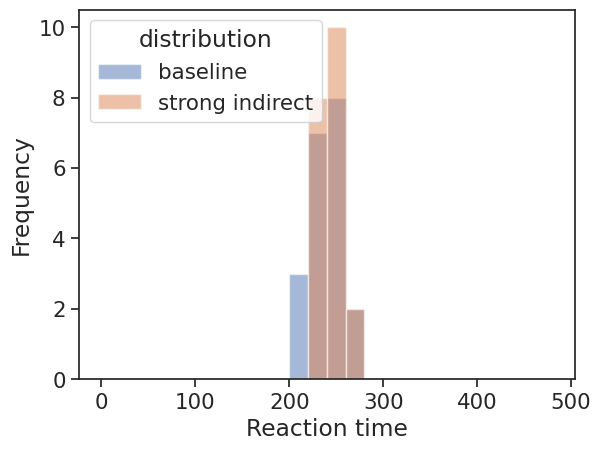

In [23]:
# plot a histogram of reaction times

plt.hist(rt_data_baseline.rt,  bins=np.arange(0,500,20), alpha=0.5, label='baseline')
plt.hist(rt_data_indirect_up.rt, bins=np.arange(0,500,20), alpha=0.5, label='strong indirect')
plt.xlabel('Reaction time')
plt.ylabel('Frequency')
plt.legend(title='distribution')

---
### Question 3.3

What was the actual relationship between indirect pathway strength and reaction time?

__Answer:__

increasing strength of indirect pathway leads to longer reaction times overall (increased freq of slower reaction times) compared to the baseline. This follows my predictions.  


---
**IMPORTANT** Did you collaborate with anyone on this assignment, or use LLMs like ChatGPT? If so, list their names here.
> *Write Name(s) here*
Destiny Lee